# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [66]:
# import libraries
import pyspark
from pyspark import  SparkConf , SparkContext
conf = SparkConf().setMaster('local')
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, stddev, split, udf, isnull, first, col, format_number, rand
from pyspark.sql.types import IntegerType, FloatType

from pyspark.ml.classification import LogisticRegression, GBTClassifier,LinearSVC, RandomForestClassifier

from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, count, when, isnull, collect_list

In [67]:
import re
import time
import datetime
from pyspark.sql.types import IntegerType
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

%matplotlib inline

In [3]:
# create a Spark session
spark = SparkSession.builder.appName('Sparkify_local').getOrCreate()

In [4]:
sns.set(style="whitegrid")

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
df = spark.read.json('mini_sparkify_event_data.json')
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### <span style='background :#318CE7' > showing somme information for each column : </span>

In [7]:
for col in df.columns :
    df.describe(col).show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+

+-------+----------+
|summary|      auth|
+-------+----------+
|  count|    286500|
|   mean|      null|
| stddev|      null|
|    min| Cancelled|
|    max|Logged Out|
+-------+----------+

+-------+---------+
|summary|firstName|
+-------+---------+
|  count|   278154|
|   mean|     null|
| stddev|     null|
|    min| Adelaida|
|    max|   Zyonna|
+-------+---------+

+-------+------+
|summary|gender|
+-------+------+
|  count|278154|
|   mean|  null|
| stddev|  null|
|    min|     F|
|    max|     M|
+-------+------+

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            286500|
|   mean|114.41421291448516|
| stddev|129.76726201140994|
|    min|                 0|
|    max| 

### <span style='background :#318CE7' > showing the number of NAN values for each column :  </span>

In [8]:
null_values = {}
for col in df.columns:
    null_values[col] = df.filter(isnull(df[col])).count()

In [9]:
null_values

{'artist': 58392,
 'auth': 0,
 'firstName': 8346,
 'gender': 8346,
 'itemInSession': 0,
 'lastName': 8346,
 'length': 58392,
 'level': 0,
 'location': 8346,
 'method': 0,
 'page': 0,
 'registration': 8346,
 'sessionId': 0,
 'song': 58392,
 'status': 0,
 'ts': 0,
 'userAgent': 8346,
 'userId': 0}

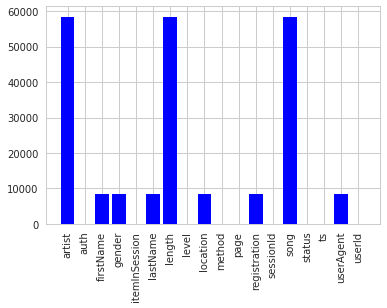

In [10]:
plt.bar(list(null_values.keys()), null_values.values(), color='b')
plt.xticks(rotation =90)
plt.show()

In [11]:
empty_values = {}
for col in df.columns:
    empty_values[col] = df.filter(df[col]=='').count()

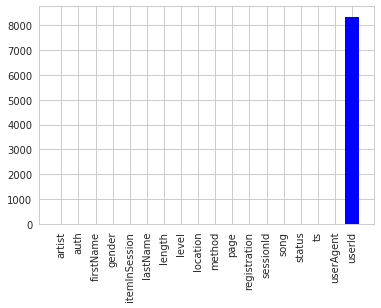

In [12]:
plt.bar(list(empty_values.keys()), empty_values.values(), color='b')
plt.xticks(rotation =90)
plt.show()

In [13]:
df = df.filter(df['userId']!='')

In [14]:
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn("date", get_time(df.ts))

In [15]:
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', date='2018-10-01 00:01:57')]

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### <span style='background :#318CE7' > 1-  Exploratory Data Analysis to Define Churn


In [16]:
#Create a temporary view to perform SQL operations
df.createOrReplaceTempView("Sparkify_local")

In [17]:
auth_count = spark.sql('''
        SELECT auth,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local
        GROUP BY auth
        ORDER BY user_counts DESC
''')

In [18]:
auth_count.show()

+---------+-----------+
|     auth|user_counts|
+---------+-----------+
|Logged In|        225|
|Cancelled|         52|
+---------+-----------+



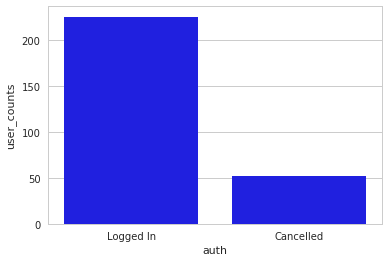

In [19]:
sns.barplot(x='auth',y='user_counts',data=auth_count.toPandas(),color='blue');

In [20]:
gender_count = spark.sql('''

        SELECT gender,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local
        GROUP BY gender
        ORDER BY user_counts DESC
''')

In [21]:
gender_count.show()

+------+-----------+
|gender|user_counts|
+------+-----------+
|     M|        121|
|     F|        104|
+------+-----------+



In [22]:
gender = gender_count.toPandas()

In [23]:
gender

,gender,user_counts
0,M,121
1,F,104


(-1.1235138391986366,
 1.1112787817866521,
 -1.1093761965572577,
 1.1254164244280309)

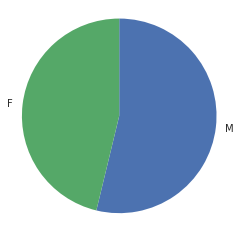

In [24]:
plt.pie(gender['user_counts'], labels = gender['gender'], startangle = 90,
        counterclock = False);
plt.axis('square')

In [25]:
length_data = spark.sql('''
        SELECT length
        FROM Sparkify_local
''')

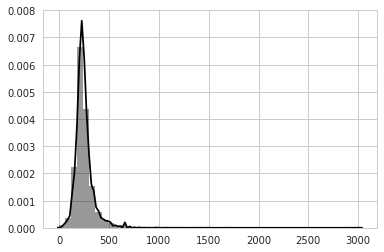

In [26]:
sns.distplot(length_data.toPandas().dropna(),color='black');

##### <span style='background :#FFC961' > it seems that Most of length are between 0 and 500.

In [27]:
level = spark.sql('''
        SELECT level,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local
        GROUP BY level
        ORDER BY user_counts DESC
''')

In [28]:
level.show()

+-----+-----------+
|level|user_counts|
+-----+-----------+
| free|        195|
| paid|        165|
+-----+-----------+



#####  <span style='background :#FFC961' > There are 195 free and 165 paid account in this dataset, in another word, there are 135 users have changed their account level.

In [29]:
pd_level = level.toPandas()

In [30]:
pd_level

,level,user_counts
0,free,195
1,paid,165


(-1.1247594318675094,
 1.1116803851075496,
 -1.1103214634464234,
 1.1261183535286357)

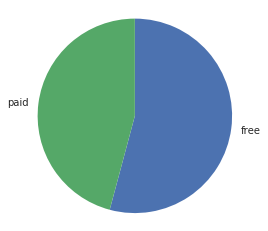

In [31]:
plt.pie(pd_level['user_counts'], labels = pd_level['level'], startangle = 90,
        counterclock = False);
plt.axis('square')

In [32]:
location_count = spark.sql('''
        SELECT location,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local
        GROUP BY location
        ORDER BY user_counts DESC
''').toPandas()

In [33]:
location_count.groupby(['user_counts']).sum()

,location
user_counts,
1,"Gainesville, FLAtlantic City-Hammonton, NJDelt..."
2,"Indianapolis-Carmel-Anderson, INSeattle-Tacoma..."
3,"San Diego-Carlsbad, CANew Haven-Milford, CTLas..."
4,"Washington-Arlington-Alexandria, DC-VA-MD-WVAt..."
5,"Miami-Fort Lauderdale-West Palm Beach, FLBosto..."
6,"St. Louis, MO-ILChicago-Naperville-Elgin, IL-I..."
7,"Phoenix-Mesa-Scottsdale, AZDallas-Fort Worth-A..."
15,"New York-Newark-Jersey City, NY-NJ-PA"
16,"Los Angeles-Long Beach-Anaheim, CA"


In [34]:
spark.sql('''
        SELECT page,COUNT(userId) AS user_counts
        FROM Sparkify_local
        GROUP BY page
        ORDER BY user_counts DESC
''').show()

+--------------------+-----------+
|                page|user_counts|
+--------------------+-----------+
|            NextSong|     228108|
|           Thumbs Up|      12551|
|                Home|      10082|
|     Add to Playlist|       6526|
|          Add Friend|       4277|
|         Roll Advert|       3933|
|              Logout|       3226|
|         Thumbs Down|       2546|
|           Downgrade|       2055|
|            Settings|       1514|
|                Help|       1454|
|             Upgrade|        499|
|               About|        495|
|       Save Settings|        310|
|               Error|        252|
|      Submit Upgrade|        159|
|    Submit Downgrade|         63|
|              Cancel|         52|
|Cancellation Conf...|         52|
+--------------------+-----------+



In [35]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- date: string (nullable = true)



In [36]:
userAgent_count = spark.sql('''
        SELECT userAgent,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local
        GROUP BY userAgent
        ORDER BY user_counts DESC
''').toPandas()

In [37]:
userAgent_count.head(3)

,userAgent,user_counts
0,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",24
1,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,18
2,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",16


In [38]:
date = spark.sql('''
        SELECT date,userId
        FROM Sparkify_local
''').toPandas()

In [39]:
date['date'] = pd.to_datetime(date['date'])

In [40]:
weekday_dict = {0:'Mon.',1:'Tues.',2:'Wed.',3:'Thur.',4:'Fri.',5:'Sat.',6:'Sun.'}
date['weekday'] = date['date'].dt.weekday.map(weekday_dict)
date['day'] = date['date'].dt.day
date['hour'] = date['date'].dt.hour

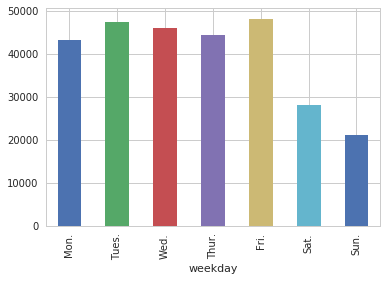

In [41]:
date.groupby('weekday')['userId'].count().loc[list(weekday_dict.values())].plot(kind='bar');

In [42]:
df.select('page').dropDuplicates().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Settings'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [43]:
create_target = udf(lambda x : 1 if x=='Cancellation Confirmation' else 0, IntegerType())

In [44]:
df = df.withColumn('Churn_state',create_target('page'))

In [45]:
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', date='2018-10-01 00:01:57', Churn_state=0)]

In [46]:
userwindow = Window.partitionBy('userId').rangeBetween(Window.unboundedPreceding,Window.unboundedFollowing)
df = df.withColumn('Churn',fmax('Churn_state').over(userwindow))

In [47]:
df.take(1)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', date='2018-10-08 12:58:54', Churn_state=0, Churn=0)]

In [48]:
df.dropDuplicates(['userId']).select('Churn').groupby('Churn').count().collect()

[Row(Churn=1, count=52), Row(Churn=0, count=173)]

In [49]:
churn_by_auth = df.dropDuplicates(["userId"]).groupby(["Churn", "auth"]).count().sort("Churn").toPandas()

In [50]:
churn_by_auth

,Churn,auth,count
0,0,Logged In,173
1,1,Logged In,52


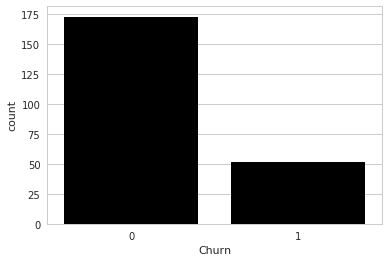

In [51]:
sns.barplot(x='Churn',y='count',data=churn_by_auth,color='black');

In [52]:
df.dropDuplicates(["userId", "gender"]).groupby(["Churn", "gender"]).count().sort("Churn").show()

+-----+------+-----+
|Churn|gender|count|
+-----+------+-----+
|    0|     M|   89|
|    0|     F|   84|
|    1|     F|   20|
|    1|     M|   32|
+-----+------+-----+



In [53]:
proportions_ztest([32,20],[121,104],alternative='two-sided')

(1.2800974409737422, 0.20051086855629463)

### <span style='background :#FFC961' >In males, churn rate is 0.264 which is 0.192 in females, but the p-value is 0.2 over 0.05, so the gender has almost no effect on Churn or not. </span>

In [54]:
df.dropDuplicates(["userId"]).groupby(["Churn", "level"]).count().sort("Churn").show()

+-----+-----+-----+
|Churn|level|count|
+-----+-----+-----+
|    0| free|  133|
|    0| paid|   40|
|    1| paid|    8|
|    1| free|   44|
+-----+-----+-----+



In [55]:
df.show(3)

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+-----------+-----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|               date|Churn_state|Churn|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+-----------+-----+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT|NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|100010|201

In [56]:
def normalize_data(groupby_data):
    
    groupby_series = groupby_data.set_index(list(groupby_data.columns[:2]))
    temp = groupby_series.unstack('Churn').fillna(0)
    df = pd.DataFrame(((temp - temp.min()) / (temp.max() - temp.min())).stack()).reset_index()
    df = df.rename(columns={df.columns[-1]:'result'})
    
    return df

In [57]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))

df = df.withColumn('hour', get_hour(df.ts))
df = df.withColumn('day', get_day(df.ts))
df = df.withColumn('dayofweek', get_weekday(df.ts))

In [58]:
hour_data = df.select(["Churn", "hour"]).groupby(["Churn", "hour"]).count().sort("hour").toPandas()
day_data = df.select(["Churn", "day"]).groupby(["Churn", "day"]).count().sort("day").toPandas()
dayofweek_data = df.select(["Churn", "dayofweek"]).groupby(["Churn", "dayofweek"]).count().sort("dayofweek").toPandas()

In [59]:
hour_data = normalize_data(hour_data)

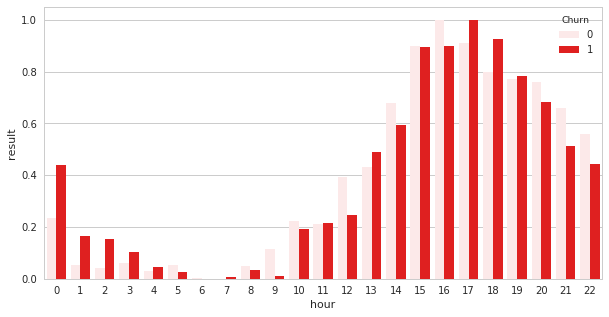

In [60]:

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot( x="hour",y="result", hue="Churn", data=hour_data,ax=ax,order=list(map(lambda x: str(x),range(23))),color='red');

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

###### <span style='background :yellow' > On the basis of the above EDA, we can create features as follows:

    .gender
    .gender
    .level
    .number of thumbs up
    .number of thumbs down 
    .number of the days on the system
    .songs played 
    .lif time
    .songs per hour

In [61]:
def get_numericals(list_cols):
    '''
    transform categorical items to number
    '''
    res = []
    for col_name in list_cols :
        col = df.select([col_name]).dropDuplicates().toPandas()
        label_dict = {val:str(idx) for idx,val in enumerate(col[col_name].tolist())}
        res.append(df.dropDuplicates(['userId']).select(['userId',col_name]).replace(label_dict,subset=col_name))
       
    data = res[0]
    for elm in range(len(res)-1):
        print(elm+1)
        data = data.join(res[elm+1],on='userId',how='inner')
    return data

In [62]:
data = get_numericals(['gender','level'])

1


In [63]:
data.show()

+------+------+-----+
|userId|gender|level|
+------+------+-----+
|100010|     0|    0|
|200002|     1|    0|
|   125|     1|    0|
|   124|     0|    1|
|    51|     1|    1|
|     7|     1|    0|
|    15|     1|    1|
|    54|     0|    1|
|   155|     0|    0|
|100014|     1|    1|
|   132|     0|    0|
|   154|     0|    0|
|   101|     1|    0|
|    11|     0|    0|
|   138|     1|    0|
|300017|     0|    1|
|100021|     1|    0|
|    29|     1|    0|
|    69|     0|    0|
|   112|     1|    0|
+------+------+-----+
only showing top 20 rows



In [64]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- date: string (nullable = true)
 |-- Churn_state: integer (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- hour: string (nullable = true)
 |-- day: string (nullable = true)
 |-- dayofweek: string (nullable = true)



In [68]:
likes = df.where(df.page=='Thumbs Up').groupby("userId").agg(count(col('page')).alias('likes')).orderBy('userId')
likes.show()

+------+-----+
|userId|likes|
+------+-----+
|    10|   37|
|   100|  148|
|100001|    8|
|100002|    5|
|100003|    3|
|100004|   35|
|100005|    7|
|100006|    2|
|100007|   19|
|100008|   37|
|100009|   23|
|100010|   17|
|100012|   18|
|100013|   39|
|100014|   17|
|100015|   35|
|100016|   25|
|100017|    2|
|100018|   46|
|100019|    1|
+------+-----+
only showing top 20 rows



In [69]:
dislikes = df.where(df.page=='Thumbs Down').groupby("userId").agg(count(col('page')).alias('dislikes')).orderBy('userId')
dislikes.show()

+------+--------+
|userId|dislikes|
+------+--------+
|    10|       4|
|   100|      27|
|100001|       2|
|100004|      11|
|100005|       3|
|100006|       2|
|100007|       6|
|100008|       6|
|100009|       8|
|100010|       5|
|100011|       1|
|100012|       9|
|100013|      15|
|100014|       3|
|100015|       8|
|100016|       5|
|100017|       1|
|100018|       9|
|100019|       1|
|100021|       5|
+------+--------+
only showing top 20 rows



In [70]:
songsPlayed = df.where(col('song')!='null').groupby("userId").agg(count(col('song')).alias('SongsPlayed')).orderBy('userId')
songsPlayed.show()

+------+-----------+
|userId|SongsPlayed|
+------+-----------+
|    10|        673|
|   100|       2682|
|100001|        133|
|100002|        195|
|100003|         51|
|100004|        942|
|100005|        154|
|100006|         26|
|100007|        423|
|100008|        772|
|100009|        518|
|100010|        275|
|100011|         11|
|100012|        476|
|100013|       1131|
|100014|        257|
|100015|        800|
|100016|        530|
|100017|         52|
|100018|       1002|
+------+-----------+
only showing top 20 rows



In [71]:
days = df.groupby('userId').agg(((max(col('ts')) - min(col('ts')))/86400000).alias("Days"))


In [72]:
songsPerHour = udf(lambda numSongs, numDays: numSongs/(numDays*24), FloatType())

In [73]:
label = df.select(['userId','Churn']).dropDuplicates()

In [74]:
label = label.select(col("userId").alias("userId"), col("Churn").alias("label"))

In [75]:
label.show()

+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
|   132|    0|
|   154|    0|
|   101|    1|
|    11|    0|
|   138|    0|
|300017|    0|
|100021|    1|
|    29|    1|
|    69|    0|
|   112|    0|
+------+-----+
only showing top 20 rows



In [76]:
lifTime = df.select('userId','registration','ts').withColumn('lifetime',(df.ts-df.registration)) \
    .groupBy('userId').agg({'lifetime':'max'}).withColumnRenamed('max(lifetime)','lifetime') \
    .select('userId', (col('lifetime')/1000/3600/24).alias('lifetime'))
lifTime.show()

+------+------------------+
|userId|          lifetime|
+------+------------------+
|100010|  55.6436574074074|
|200002| 70.07462962962963|
|   125| 71.31688657407408|
|    51|19.455844907407407|
|   124|131.55591435185184|
|     7| 72.77818287037037|
|    54|110.75168981481481|
|    15|56.513576388888886|
|   155|23.556018518518517|
|   132|  66.8891087962963|
|   154|23.872037037037035|
|100014| 85.08340277777778|
|   101|53.965937499999995|
|    11|124.47825231481481|
|   138| 66.62668981481481|
|300017| 74.35851851851852|
|    29|60.104050925925925|
|    69| 71.42444444444445|
|100021| 64.73886574074074|
|    42| 67.11364583333334|
+------+------------------+
only showing top 20 rows



In [77]:
label.show()

+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
|   132|    0|
|   154|    0|
|   101|    1|
|    11|    0|
|   138|    0|
|300017|    0|
|100021|    1|
|    29|    1|
|    69|    0|
|   112|    0|
+------+-----+
only showing top 20 rows



In [78]:
#df.summary()

In [79]:
def get_data_for_train():
    
    """
    INPUT : none 
    OUTPUT: data ready to train and test 
    
    merge all the data created for the project and fill the messing data
    """
    data = get_numericals(['gender','level'])
    #label = df.select(['userId','label']).dropDuplicates()
    reactions = likes.join(dislikes,'userId')
    df_features  = reactions.join(songsPlayed,'userId').join(data,'userId')
    df_features  = df_features.join(days,'userId')
    df_features = df_features.withColumn("SongsPerHour", songsPerHour(df_features.SongsPlayed, df_features.Days))
    df_features  = df_features.join(lifTime,'userId')
    df_features  = df_features.join(label,'userId')
    
    
    df_features = df_features.na.fill(0)
    
    return df_features

In [80]:
df_features = get_data_for_train()

1


In [81]:
df_features.show()

+------+-----+--------+-----------+------+-----+------------------+------------+------------------+-----+
|userId|likes|dislikes|SongsPlayed|gender|level|              Days|SongsPerHour|          lifetime|label|
+------+-----+--------+-----------+------+-----+------------------+------------+------------------+-----+
|100010|   17|       5|        275|     0|    0| 44.21780092592593|  0.25913393|  55.6436574074074|    0|
|200002|   21|       6|        387|     1|    0|45.496805555555554|  0.35442048| 70.07462962962963|    0|
|   124|  171|      41|       4079|     0|    1|59.996944444444445|   2.8327832|131.55591435185184|    0|
|    51|  100|      21|       2111|     1|    1|15.779398148148148|   5.5742517|19.455844907407407|    1|
|     7|    7|       1|        150|     1|    0|50.784050925925925| 0.123070136| 72.77818287037037|    0|
|    15|   81|      14|       1914|     1|    1| 54.77318287037037|   1.4560045|56.513576388888886|    0|
|    54|  163|      29|       2841|     0|    

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [82]:
df_features = df_features.withColumn("userId",df_features["userId"].cast(IntegerType()))
df_features = df_features.withColumn("gender",df_features["gender"].cast(IntegerType()))
df_features = df_features.withColumn("level",df_features["level"].cast(IntegerType()))

In [83]:
df_features.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- likes: long (nullable = false)
 |-- dislikes: long (nullable = false)
 |-- SongsPlayed: long (nullable = false)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- Days: double (nullable = false)
 |-- SongsPerHour: float (nullable = false)
 |-- lifetime: double (nullable = false)
 |-- label: integer (nullable = true)



###  <span style='background :#318CE7' >  Implement standscaler on features

In [84]:
cols = ["likes", "dislikes", "SongsPlayed","gender",'level','Days','SongsPerHour','lifetime']
assembler = VectorAssembler(inputCols=cols, outputCol="NumFeatures")
data = assembler.transform(df_features)

In [85]:
scaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

In [86]:
train, rest = data.randomSplit([0.6, 0.4], seed=42)
validation, test = rest.randomSplit([0.5, 0.5], seed=42)

In [87]:
results_base_all_1 = test.withColumn('prediction', lit(1.0))

In [88]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Test set metrics:')
print('Accuracy: -------------> {}'.format(evaluator.evaluate(results_base_all_1, {evaluator.metricName: "accuracy"})))
print('F-1 Score:-------------> {}'.format(evaluator.evaluate(results_base_all_1, {evaluator.metricName: "f1"})))

Test set metrics:
Accuracy: 0.21875
F-1 Score:0.07852564102564102


In [89]:
results_base_all_0 = test.withColumn('prediction', lit(0.0))

In [90]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Test set metrics:')
print('Accuracy: -----------> {}'.format(evaluator.evaluate(results_base_all_0, {evaluator.metricName: "accuracy"})))
print('F-1 Score:-----------> {}'.format(evaluator.evaluate(results_base_all_0, {evaluator.metricName: "f1"})))

Test set metrics:
Accuracy: 0.78125
F-1 Score:0.6853070175438596


In [91]:
lr = LogisticRegression(maxIter=10)

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder().build()

crossval_lr = CrossValidator(estimator=lr,
                          evaluator=f1_evaluator, 
                          estimatorParamMaps=paramGrid,
                          numFolds=3)

In [92]:
from time import time

In [1]:
start = time()
cvModel_lr = crossval_lr.fit(train)
end = time()
cvModel_lr.avgMetrics
print('The training process took {} min'.format(end - start)/60)


NameError: name 'time' is not defined

In [94]:
results_lr = cvModel_lr.transform(validation)

In [95]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Logistic Regression Metrics:')
print('Accuracy : ------------> {}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "accuracy"})))
print('F-1 Score: ------------> {}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "f1"})))

Logistic Regression Metrics:
Accuracy: 0.75
F-1 Score:0.7333333333333334


In [96]:
# initialize classifier
gbt = GBTClassifier(maxIter=10,seed=42)

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder().build()

crossval_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=3)

In [97]:
start = time()
cvModel_gbt = crossval_gbt.fit(train)
end = time()
cvModel_gbt.avgMetrics
print('The training process took {} min '.format(end - start)/60)

The training process took 949.2887496948242 seconds


In [98]:
results_gbt = cvModel_gbt.transform(validation)

In [99]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Gradient Boosted Trees Metrics:')
print('Accuracy : ---------------> {}'.format(evaluator.evaluate(results_gbt, {evaluator.metricName: "accuracy"})))
print('F-1 Score: ---------------> {}'.format(evaluator.evaluate(results_gbt, {evaluator.metricName: "f1"})))

Gradient Boosted Trees Metrics:
Accuracy: 0.5833333333333334
F-1 Score:0.495798319327731


In [100]:

# initialize classifier
svm = LinearSVC(maxIter=10)

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

paramGrid = ParamGridBuilder().build()

crossval_svm = CrossValidator(estimator=svm,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=3)

In [101]:
start = time()
cvModel_svm = crossval_svm.fit(train)
end = time()
cvModel_svm.avgMetrics
print('The training process took {} min'.format(end - start)/60)

The training process took 605.0555768013 seconds


In [102]:
results_svm = cvModel_svm.transform(validation)


In [103]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('SVM Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_svm, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_svm, {evaluator.metricName: "f1"})))

SVM Metrics:
Accuracy: 0.5833333333333334
F-1 Score:0.495798319327731


In [104]:
rf = RandomForestClassifier()

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder().build()

crossval_rf = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=3)

In [105]:
start = time()
cvModel_rf = crossval_rf.fit(train)
end = time()
cvModel_rf.avgMetrics
print('The training process took {} min'.format(end - start)/60)

The training process took 509.4997441768646 seconds


In [106]:
results_rf = cvModel_rf.transform(validation)

In [107]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Random Forest Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_rf, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_rf, {evaluator.metricName: "f1"})))

Random Forest Metrics:
Accuracy: 0.8333333333333334
F-1 Score:0.8285714285714286


In [108]:
GBTClassifier(maxIter=10,seed=42)

paramGrid_gbt = ParamGridBuilder().addGrid(gbt.maxDepth,[5, 10]).addGrid(gbt.maxIter, [10,15]).build()

f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

crossval_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid_gbt,
                          evaluator=f1_evaluator,
                          numFolds=3)

In [109]:
cvModel_gbt = crossval_gbt.fit(train)
cvModel_gbt.avgMetrics

[0.7719720154333474,
 0.7782623892552261,
 0.7598131460376358,
 0.7598131460376358]

In [110]:
gbt_best = GBTClassifier(maxIter=10,seed=42, maxDepth=5)
gbt_best_model = gbt_best.fit(train)
results_final = gbt_best_model.transform(test)

In [111]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Test set metrics:')
print('Accuracy : -----------> {}'.format(evaluator.evaluate(results_final, {evaluator.metricName: "accuracy"})))
print('F-1 Score: -----------> {}'.format(evaluator.evaluate(results_final, {evaluator.metricName: "f1"})))

Test set metrics:
Accuracy: 0.75
F-1 Score:0.7499999999999999


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

#  <span style='background :#318CE7' > Reflection
<span style='background :#FFC961' > This project gives exposure to spark environment to analyze a large volume of data that a personal laptop may not be capable to analyze. By identifying customer with high chance to churn prior to the acutal losing, companies are able to use minimal cost to save customers by using targeted messages and offers.

<span style='background :#FFC961' > One of the interesting yet difficult things during the project is brainstroming the features that we can derived from the data we have on hand. Developing useful features is crucial to developing a good model, and requires a lot of energy and efforts. Explanatory and exploratory data analysis play important role in this process.

#  <span style='background :#318CE7' > Improvement
<span style='background :#FFC961' > The features can be improved a lot after considering more factors, adding more domain knowledges and expertise. Although the volume of data may required tools such as spark to analyze, but we can use more data to have better results as the user base grow.

<span style='background :#FFC961' > Currently, we have about 450 records of unique users, and we only use 60% of them to train. That said, the model has a huge potential to improve if the sample size increase, and the expected performance will also increase.

# <span style='background :#318CE7' > conclusion

<span style='background :#FFC961' > As we can see from the result the predictions are enough good. The use of RandomForestClassifier let us predict users' future actions with high accuracy. The main pain points of this analysis were feature engineering and pipeline creation as they are slightly different with pyspark&ml than with python&scikitlearn.

<span style='background :#FFC961' > This analysis was done in the workspace provided by Udacity and on the data set mini_sparkify_event_data.json of small size and inspired by the materials learned during the lessons. The next is to continue the analysis on the full dataset is of size 12GB in cloud…

# my post  
https://medium.com/@hider.tla/churn-analysis-using-pyspark-dccfea13035f